In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

# Define the network with an optional fast-weights dictionary.
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 14 * 14)
        self.fc2 = nn.Linear(14 * 14, 7 * 7)
        self.fc3 = nn.Linear(7 * 7, 10)
    
    def forward(self, x, params=None):
        x = x.view(x.size(0), -1)
        if params is None:
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
        else:
            x = F.linear(x, params['fc1.weight'], params['fc1.bias'])
            x = F.relu(x)
            x = F.linear(x, params['fc2.weight'], params['fc2.bias'])
            x = F.relu(x)
            x = F.linear(x, params['fc3.weight'], params['fc3.bias'])
        return x

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Synthetic Data Initialization (using a smaller variance)
num_classes = 10
images_per_class = 10  # 10 synthetic images per class
total_syn = num_classes * images_per_class
synthetic_data = nn.Parameter(torch.randn(total_syn, 1, 28, 28, device=device) * 0.1)
synthetic_labels = torch.tensor([i for i in range(num_classes) for _ in range(images_per_class)], device=device)

# Real Data Loader
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
real_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)

# Outer optimizer: using Adam for more stable updates
outer_optimizer = optim.Adam([synthetic_data], lr=0.001)
criterion = nn.CrossEntropyLoss()

# Hyperparameters for the inner loop
num_inner_steps = 20   # increased from 5 to 20 steps
inner_lr = 0.01

# Training loop: meta model matching process
for epoch in range(5):
    for real_images, real_labels in real_loader:
        real_images, real_labels = real_images.to(device), real_labels.to(device)
        
        # Initialize a fresh meta-model for each iteration
        model = SimpleNet().to(device)
        fast_weights = {name: param.clone().detach().requires_grad_(True)
                        for name, param in model.named_parameters()}
        
        # ---- Inner Loop: Perform multiple gradient updates on synthetic data ----
        for _ in range(num_inner_steps):
            syn_logits = model.forward(synthetic_data, params=fast_weights)
            inner_loss = criterion(syn_logits, synthetic_labels)
            
            grads = torch.autograd.grad(
                inner_loss, list(fast_weights.values()), create_graph=True, allow_unused=True
            )
            
            fast_weights = {
                name: param - inner_lr * (grad if grad is not None else torch.zeros_like(param))
                for (name, param), grad in zip(fast_weights.items(), grads)
            }
        
        # ---- Meta Evaluation: Compute loss on real data using updated fast weights ----
        meta_logits = model.forward(real_images, params=fast_weights)
        meta_loss = criterion(meta_logits, real_labels)
        
        # ---- Outer Loop: Update synthetic data to minimize the meta loss ----
        outer_optimizer.zero_grad()
        meta_loss.backward()
        outer_optimizer.step()
        
        # Debugging: Check gradient norm of synthetic_data
        grad_norm = synthetic_data.grad.norm().item() if synthetic_data.grad is not None else 0.0
        print(f"Epoch {epoch}, Meta Loss: {meta_loss.item()}, Synthetic Data Grad Norm: {grad_norm}")


Epoch 0, Meta Loss: 2.3014073371887207, Synthetic Data Grad Norm: 0.00023451208835467696
Epoch 0, Meta Loss: 2.3062636852264404, Synthetic Data Grad Norm: 0.00018316101341042668
Epoch 0, Meta Loss: 2.2943055629730225, Synthetic Data Grad Norm: 0.00022500810155179352
Epoch 0, Meta Loss: 2.338576078414917, Synthetic Data Grad Norm: 0.0002465610159561038
Epoch 0, Meta Loss: 2.2824208736419678, Synthetic Data Grad Norm: 0.00019406000501476228
Epoch 0, Meta Loss: 2.293628215789795, Synthetic Data Grad Norm: 0.00020671387028414756
Epoch 0, Meta Loss: 2.325824737548828, Synthetic Data Grad Norm: 0.00021623716747853905
Epoch 0, Meta Loss: 2.3228230476379395, Synthetic Data Grad Norm: 0.00023001639056019485
Epoch 0, Meta Loss: 2.313199043273926, Synthetic Data Grad Norm: 0.00020561102428473532
Epoch 0, Meta Loss: 2.3036396503448486, Synthetic Data Grad Norm: 0.00016873315325938165
Epoch 0, Meta Loss: 2.30584454536438, Synthetic Data Grad Norm: 0.0002702000201679766
Epoch 0, Meta Loss: 2.3087530

Step [0/1500], Loss: 0.0046
Step [100/1500], Loss: 0.0045
Step [200/1500], Loss: 0.0046
Step [300/1500], Loss: 0.0047
Step [400/1500], Loss: 0.0047
Step [500/1500], Loss: 0.0046
Step [600/1500], Loss: 0.0048
Step [700/1500], Loss: 0.0047
Step [800/1500], Loss: 0.0045
Step [900/1500], Loss: 0.0048
Step [1000/1500], Loss: 0.0046
Step [1100/1500], Loss: 0.0047
Step [1200/1500], Loss: 0.0047
Step [1300/1500], Loss: 0.0047
Step [1400/1500], Loss: 0.0047


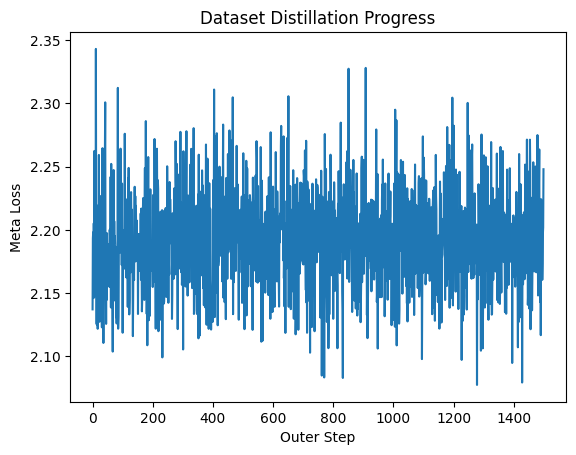

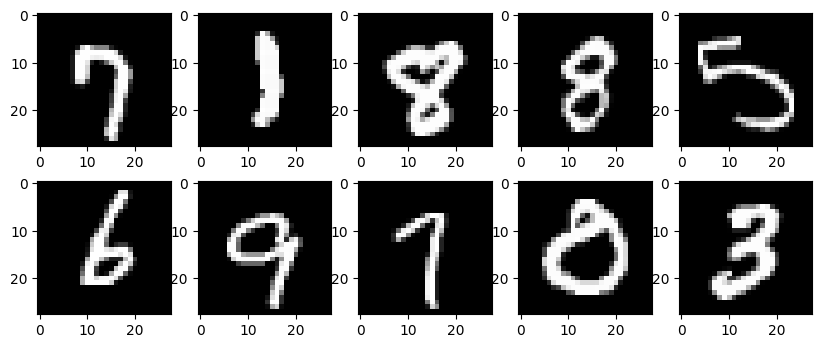

Epoch [1/10], Loss: 2.2859
Epoch [2/10], Loss: 2.2038
Epoch [3/10], Loss: 2.1286
Epoch [4/10], Loss: 2.0506
Epoch [5/10], Loss: 1.9695
Epoch [6/10], Loss: 1.8799
Epoch [7/10], Loss: 1.7825
Epoch [8/10], Loss: 1.6783
Epoch [9/10], Loss: 1.5695
Epoch [10/10], Loss: 1.4561


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import numpy as np


# Corrected SimpleNet
class BetterNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        return self.fc3(x)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_classes = 10
input_dim = 28 * 28
syn_size = 50  # 50 synthetic images
inner_steps = 150  # Inner loop steps
outer_steps = 1500  # Outer loop steps
lr_syn = 0.01  # Reduced from 0.1
lr_model = 0.001  # Reduced from 0.01

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Initialize synthetic data with real images (critical for MNIST)
real_images, real_labels = next(iter(train_loader))
syn_images = real_images[:syn_size].clone().detach().requires_grad_(True).to(device)
syn_labels = nn.functional.one_hot(real_labels[:syn_size], num_classes).float().requires_grad_(True).to(device)

# Optimizer for synthetic data
optimizer_syn = optim.Adam([syn_images, syn_labels], lr=lr_syn)  # Use Adam instead of SGD

# Loss tracking
meta_losses = []


for outer_step in range(outer_steps):
    # Initialize fresh model
    model = BetterNet().to(device)
    optimizer_model = optim.Adam(model.parameters(), lr=lr_model)
    
    # --------------------------------------
    # Inner loop: Train on synthetic data
    # --------------------------------------
    inner_steps = 3  # Reduced from 5 (prevent overfitting to synthetic data)
    # Add to training loop:
    for _ in range(inner_steps):
        outputs = model(syn_images)
        loss = nn.CrossEntropyLoss()(outputs, syn_labels.argmax(dim=1)) + 0.001 * torch.norm(syn_images)  # L2 regularization

        # Update model parameters
        optimizer_model.zero_grad()
        loss.backward()
        optimizer_model.step()
    
    # --------------------------------------
    # Outer loop: Meta-optimization
    # --------------------------------------
    # Outer loop with gradient clipping
    meta_loss = 0.0
    for real_images, real_labels in train_loader:
        real_images, real_labels = real_images.to(device), real_labels.to(device)
        outputs_real = model(real_images)
        loss_real = nn.CrossEntropyLoss()(outputs_real, real_labels)
        
        optimizer_syn.zero_grad()
        loss_real.backward()
        torch.nn.utils.clip_grad_norm_([syn_images, syn_labels], 1.0)
        optimizer_syn.step()
        
        meta_loss += loss_real.item()
        meta_losses.append(meta_loss)
        break
    
    meta_loss /= len(train_loader)
    if outer_step % 100 == 0:
        print(f'Step [{outer_step}/{outer_steps}], Loss: {meta_loss:.4f}')
        
        
# Plot learning curve
import matplotlib.pyplot as plt
plt.plot(meta_losses)
plt.xlabel('Outer Step')
plt.ylabel('Meta Loss')
plt.title('Dataset Distillation Progress')
plt.show()

plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(syn_images[i].detach().cpu().squeeze(), cmap='gray')
plt.show()

# Validate distilled data
syn_dataset = TensorDataset(syn_images.detach(), syn_labels.argmax(dim=1))
syn_loader = DataLoader(syn_dataset, batch_size=128, shuffle=True)

# Train final model
final_model = SimpleNet().to(device)
optimizer_final = optim.SGD(final_model.parameters(), lr=0.1)

for epoch in range(10):
    for images, labels in syn_loader:
        outputs = final_model(images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        
        optimizer_final.zero_grad()
        loss.backward()
        optimizer_final.step()
    
    print(f'Epoch [{epoch+1}/10], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 2.2916 

Epoch [2/10], Loss: 2.2182 

Epoch [3/10], Loss: 2.1520  

Epoch [4/10], Loss: 2.0835 

Epoch [5/10], Loss: 2.0089 

Epoch [6/10], Loss: 1.9247 

Epoch [7/10], Loss: 1.8318 

Epoch [8/10], Loss: 1.7310 

Epoch [9/10], Loss: 1.6245 

Epoch [10/10], Loss: 1.5150 

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

# ---------------------------
# Define the simple neural network
# ---------------------------
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        # Flatten the input image
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# ---------------------------
# Functional forward that uses a given parameter dictionary.
# This allows us to “simulate” an inner update on the model parameters.
# ---------------------------
def functional_forward(x, params):
    # x: [batch, 1, 28, 28] -> flatten to [batch, 28*28]
    x = x.view(x.size(0), -1)
    x = F.linear(x, params['fc1.weight'], params['fc1.bias'])
    x = F.relu(x)
    x = F.linear(x, params['fc2.weight'], params['fc2.bias'])
    x = F.relu(x)
    x = F.linear(x, params['fc3.weight'], params['fc3.bias'])
    return x

# ---------------------------
# Main training loop for meta-model matching based distillation.
# ---------------------------
def main():
    # Hyperparameters
    num_meta_iterations = 3000         # number of meta-iterations (outer loop)
    num_inner_steps = 50               # number of inner gradient steps (can be >1)
    lr_inner = 0.01                   # inner-loop (model) learning rate
    lr_meta = 0.01                     # meta (synthetic data) learning rate

    num_synthetic_per_class = 10      # number of synthetic examples per class
    num_classes = 10
    num_synthetic = num_synthetic_per_class * num_classes

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # ---------------------------
    # Create the learnable synthetic dataset
    # ---------------------------
    # Initialize synthetic images as learnable parameters.
    synthetic_images = torch.nn.Parameter(torch.randn(num_synthetic, 1, 28, 28, device=device))
    # For simplicity, we fix the synthetic labels (e.g. 10 examples per class)
    synthetic_labels = torch.tensor(np.repeat(np.arange(num_classes), num_synthetic_per_class), dtype=torch.long, device=device)

    # ---------------------------
    # Prepare the real MNIST training data
    # ---------------------------
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    real_loader = DataLoader(mnist_train, batch_size=64, shuffle=True, drop_last=True)
    real_loader_iter = iter(real_loader)

    # Meta-optimizer for the synthetic images
    optimizer_syn = optim.SGD([synthetic_images], lr=lr_meta)

    # ---------------------------
    # Meta-training loop
    # ---------------------------
    for meta_iter in range(num_meta_iterations):
        # Initialize a fresh model
        model = SimpleNN().to(device)
        # Extract initial parameters into a dictionary.
        # We use a fixed ordering to ensure consistency.
        params = {name: param for name, param in model.named_parameters()}
        param_names = list(params.keys())

        # ---------------------------
        # Inner loop: update model parameters using synthetic data
        # ---------------------------
        for step in range(num_inner_steps):
            # Forward pass on synthetic data using the current parameters.
            outputs_syn = functional_forward(synthetic_images, params)
            loss_syn = F.cross_entropy(outputs_syn, synthetic_labels)
            # Compute gradients w.r.t. the model parameters (create_graph=True for meta-gradient)
            grads = torch.autograd.grad(loss_syn, [params[name] for name in param_names], create_graph=True)
            # Perform a gradient descent update on the parameters (inner update)
            params = {name: params[name] - lr_inner * grad for name, grad in zip(param_names, grads)}

        # ---------------------------
        # Outer loop: evaluate updated model on a batch of real data
        # ---------------------------
        # Get a batch from the real MNIST training set
        try:
            real_images, real_labels = next(real_loader_iter)
        except StopIteration:
            real_loader_iter = iter(real_loader)
            real_images, real_labels = next(real_loader_iter)
        real_images, real_labels = real_images.to(device), real_labels.to(device)
        
        # Compute the loss on the real data using the updated model parameters.
        outputs_real = functional_forward(real_images, params)
        loss_real = F.cross_entropy(outputs_real, real_labels)
        
        # Backpropagate the meta-loss through the inner loop update to update synthetic images.
        optimizer_syn.zero_grad()
        loss_real.backward()
        optimizer_syn.step()

        if meta_iter % 50 == 0:
            print(f'Meta iteration {meta_iter:03d} | Meta loss (real data loss): {loss_real.item():.4f}')

    # ---------------------------
    # Save or visualize the distilled (synthetic) images
    # ---------------------------
    # Clamp the synthetic images to a valid range for visualization (e.g., [0,1])
    distilled_images = synthetic_images.detach().cpu().clamp(0, 1)
    # Optionally, save the synthetic images using torchvision's utils
    from torchvision.utils import save_image
    save_image(distilled_images, 'distilled_mnist.png', nrow=num_synthetic_per_class)
    print("Distilled images saved to distilled_mnist.png")

if __name__ == '__main__':
    main()


Meta iteration 000 | Meta loss (real data loss): 2.3123
Meta iteration 050 | Meta loss (real data loss): 2.2965
Meta iteration 100 | Meta loss (real data loss): 2.3074
Meta iteration 150 | Meta loss (real data loss): 2.3307
Meta iteration 200 | Meta loss (real data loss): 2.2900
Meta iteration 250 | Meta loss (real data loss): 2.3089
Meta iteration 300 | Meta loss (real data loss): 2.3162
Meta iteration 350 | Meta loss (real data loss): 2.2939
Meta iteration 400 | Meta loss (real data loss): 2.3046
Meta iteration 450 | Meta loss (real data loss): 2.3015
Meta iteration 500 | Meta loss (real data loss): 2.2970
Meta iteration 550 | Meta loss (real data loss): 2.3034
Meta iteration 600 | Meta loss (real data loss): 2.3112
Meta iteration 650 | Meta loss (real data loss): 2.3167
Meta iteration 700 | Meta loss (real data loss): 2.2960
Meta iteration 750 | Meta loss (real data loss): 2.2991
Meta iteration 800 | Meta loss (real data loss): 2.2900
Meta iteration 850 | Meta loss (real data loss):

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.func import functional_call
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##############################
# Define a simple CNN model
##############################
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)  # Output: (32, 26, 26)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)          # Output: (32, 13, 13)
        self.fc = nn.Linear(32 * 13 * 13, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

##############################
# Hyperparameters
##############################
num_classes = 10
ipc = 10                         # images per class in synthetic set
num_syn = num_classes * ipc      # total synthetic images
inner_steps = 100                # number of inner-loop (synthetic training) steps
meta_iterations = 1000           # meta-iterations for distillation
lr_model = 0.01                  # inner-loop learning rate
lr_syn = 0.1                     # synthetic data learning rate

# Loss function
criterion = nn.CrossEntropyLoss()

##############################
# Load MNIST dataset (real data)
##############################
transform = transforms.Compose([
    transforms.ToTensor(),  # converts images to [0,1] tensors
])
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
real_loader = DataLoader(mnist_train, batch_size=256, shuffle=True)

##############################
# Initialize synthetic dataset
##############################
# Synthetic images: parameter tensor of shape (num_syn, 1, 28, 28)
syn_images = torch.randn(num_syn, 1, 28, 28, device=device, requires_grad=True)
# Synthetic labels: for each class repeated ipc times (0,...,9)
syn_labels = torch.tensor([i for i in range(num_classes) for _ in range(ipc)], device=device)

# Optimizer for synthetic images
syn_optimizer = optim.SGD([syn_images], lr=lr_syn)

##############################
# Helper: Inner-loop update (using functional updates)
##############################
def inner_loop(model, init_params, syn_images, syn_labels, inner_steps, lr_model):
    params = init_params
    for t in range(inner_steps):
        # Forward pass on synthetic data using the current parameters
        outputs = functional_call(model, params, syn_images)
        loss = criterion(outputs, syn_labels)
        # Compute gradients w.r.t. model parameters (create_graph=True to enable second-order gradients)
        grads = torch.autograd.grad(loss, params.values(), create_graph=True)
        # Update each parameter functionally
        params = {name: param - lr_model * grad 
                  for (name, param), grad in zip(params.items(), grads)}
    return params

##############################
# Meta-training loop (distillation)
##############################
print("Starting meta-training (dataset distillation)...")
for meta_iter in range(meta_iterations):
    # Initialize a new model and get its parameters as a dict (these are the "inner-loop" model parameters)
    model = SimpleCNN().to(device)
    model.train()
    init_params = {name: param.clone() for name, param in model.named_parameters()}

    # Perform inner-loop updates using the current synthetic dataset
    for t in range(inner_steps):
        # Forward pass on synthetic data using the current parameters
        outputs = functional_call(model, init_params, syn_images)
        loss = criterion(outputs, syn_labels)
        # Compute gradients w.r.t. model parameters (create_graph=True to enable second-order gradients)
        grads = torch.autograd.grad(loss, init_params.values(), create_graph=True)
        # Update each parameter functionally
        final_params = {name: param - lr_model * grad 
                  for (name, param), grad in zip(init_params.items(), grads)}
    
    # Sample a batch from the real dataset to compute meta-loss
    try:
        real_batch = next(real_iter)
    except Exception:
        real_iter = iter(real_loader)
        real_batch = next(real_iter)
    real_imgs, real_lbls = real_batch
    real_imgs, real_lbls = real_imgs.to(device), real_lbls.to(device)
    
    # Evaluate the model (with final_params) on real data and compute meta-loss
    meta_outputs = functional_call(model, final_params, real_imgs)
    meta_loss = criterion(meta_outputs, real_lbls)
    
    # Backpropagate meta-loss through the inner loop to update synthetic images
    syn_optimizer.zero_grad()
    meta_loss.backward()
    syn_optimizer.step()

    # Clamp synthetic images to [0,1] for valid pixel values
    with torch.no_grad():
        syn_images.clamp_(0, 1)

    if meta_iter % 100 == 0:
        print(f"Meta iteration {meta_iter}: Meta loss = {meta_loss.item():.4f}")

print("Meta-training finished.")

##############################
# Evaluation: Train a new model on the distilled synthetic dataset
##############################
print("Training evaluation model on distilled synthetic dataset...")

# Create a TensorDataset and DataLoader from the distilled synthetic images
syn_dataset = TensorDataset(syn_images.detach().cpu(), syn_labels.cpu())
syn_loader = DataLoader(syn_dataset, batch_size=64, shuffle=True)

# Initialize a new model for evaluation
eval_model = SimpleCNN().to(device)
eval_model.train()
eval_optimizer = optim.SGD(eval_model.parameters(), lr=lr_model)

# Train on synthetic data for a few epochs
num_epochs = 10
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for imgs, labels in syn_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        eval_optimizer.zero_grad()
        outputs = eval_model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        eval_optimizer.step()
        epoch_loss += loss.item() * imgs.size(0)
    epoch_loss /= len(syn_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Synthetic training loss: {epoch_loss:.4f}")

##############################
# Test the evaluation model on the MNIST test set
##############################
print("Evaluating on MNIST test set...")
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

eval_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = eval_model(imgs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
test_acc = 100.0 * correct / total
print(f"Test accuracy of model trained on distilled data: {test_acc:.2f}%")


Starting meta-training (dataset distillation)...


/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_57375/355010041.py:71: FutureWarning: `torch.nn.utils.stateless.functional_call` is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use `torch.func.functional_call` instead which is a drop-in replacement.
  outputs = functional_call(model, params, syn_images)
/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_57375/355010041.py:103: FutureWarning: `torch.nn.utils.stateless.functional_call` is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use `torch.func.functional_call` instead which is a drop-in replacement.
  meta_outputs = functional_call(model, final_params, real_imgs)


Meta iteration 0: Meta loss = 2.3981
Meta iteration 100: Meta loss = 2.3102
Meta iteration 200: Meta loss = 2.2653
Meta iteration 300: Meta loss = 2.2586
Meta iteration 400: Meta loss = 2.1784
Meta iteration 500: Meta loss = 2.1683
Meta iteration 600: Meta loss = 2.1695
Meta iteration 700: Meta loss = 2.1318
Meta iteration 800: Meta loss = 2.1251
Meta iteration 900: Meta loss = 2.0605
Meta-training finished.
Training evaluation model on distilled synthetic dataset...
Epoch 1/10, Synthetic training loss: 2.3476
Epoch 2/10, Synthetic training loss: 2.3302
Epoch 3/10, Synthetic training loss: 2.2944
Epoch 4/10, Synthetic training loss: 2.3114
Epoch 5/10, Synthetic training loss: 2.2747
Epoch 6/10, Synthetic training loss: 2.2407
Epoch 7/10, Synthetic training loss: 2.2218
Epoch 8/10, Synthetic training loss: 2.2263
Epoch 9/10, Synthetic training loss: 2.2010
Epoch 10/10, Synthetic training loss: 2.1987
Evaluating on MNIST test set...
Test accuracy of model trained on distilled data: 13.54